# Corregir superposición

Para este ejemplo vamos a depurar la superposición de entidades vectoriales, de tipo **poligono**, de una misma capa:

Comenzaremos importando las librerías a utilizar:

In [1]:
import geopandas as gpd
import pandas as pd

A continuación, cargaremos la capa de tipo polígono **Sectores**

In [2]:
sectores = gpd.read_file('datos/sectores.shp')

In [3]:
sectores.head()

,id,geometry
0,1,"POLYGON ((-77.07715 -11.94747, -77.07402 -11.9..."
1,2,"POLYGON ((-77.07166 -11.94596, -77.07132 -11.9..."
2,3,"POLYGON ((-77.07695 -11.94743, -77.07589 -11.9..."
3,4,"POLYGON ((-77.07979 -11.95468, -77.07602 -11.9..."
4,5,"POLYGON ((-77.07400 -11.95397, -77.07387 -11.9..."


Vamos a plotear la capa de modo tal que nos permita verifica si esta presenta superposición:

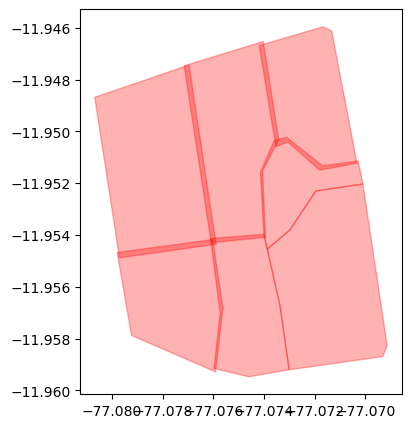

In [4]:
sectores.plot(color='red', alpha=.3, edgecolor='red', figsize= (5,5));

Como se observa en el gráfico, existen varios polígonos que presentan superposición.

A continuación, vamos a crear una función que tome como parámetros el **GeoDataFrame** y el nombre del campo que almacena la **geometría** y retorne un nuevo **GeoDataFrame** con la superposición corregida.

In [5]:
def cleanOverlay(gdfIn, geom):
    gdf = gdfIn.copy()
    for idx, row in gdf.iterrows():
        for idx2, row2 in gdf.iterrows():
            noEquals = not row[geom].equals(row2[geom])
            siIntersects = row[geom].intersects(row2[geom])
            if noEquals and siIntersects:
                gdf.at[idx, geom] = gdf.at[idx, geom].difference(row2[geom])
    return gdf

Ejecutando la función

In [6]:
sectoresClean = cleanOverlay(sectores, 'geometry')

Visualaremos el resultado

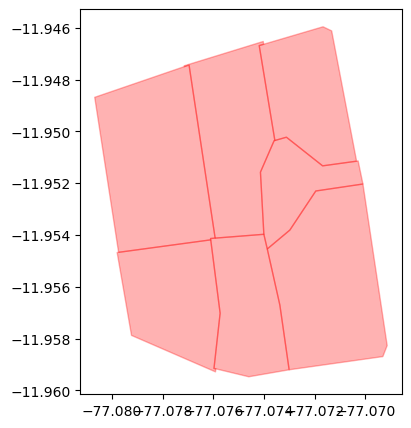

In [7]:
sectoresClean.plot(color='red', alpha=.3, edgecolor='red', figsize= (5,5));

Antes de exportar los datos visualizemos los tipos de geometría:

In [8]:
sectoresClean.geometry.geom_type.value_counts()

Polygon    7
dtype: int64

Como se observan todos son de tipo poligono, asi que no realizaremos ningun proceso de homologación de geometrias.

Finalmente, exportaremos la nueva capa como shapefile

In [9]:
sectoresClean.to_file('datos/SectoresClean.shp')

## **Reutilizando la funcion**

Reutilizaremos la función para corregir la superposición de una capa de Zonas Catastrales

In [10]:
zonas = gpd.read_file('datos/zonas.shp')

Visualizaremos los atributos

In [11]:
zonas.head()

,OBJECTID,ID_DIST,COD_ZONA,ID_ZONA,SHAPE.AREA,SHAPE.LEN,geometry
0,1,200605,99,20060599,0.0,0.0,"POLYGON ((-80.76846 -4.84790, -80.76869 -4.847..."
1,2,200401,06,20040106,0.0,0.0,"POLYGON ((-80.16641 -5.09945, -80.16684 -5.100..."
2,3,140113,05,14011305,0.0,0.0,"POLYGON ((-79.81545 -6.88408, -79.81983 -6.891..."
3,4,200104,15,20010415,0.0,0.0,"POLYGON ((-80.62272 -5.21333, -80.62684 -5.220..."
4,5,200104,03,20010403,0.0,0.0,"POLYGON ((-80.60302 -5.18579, -80.60187 -5.189..."


Reutilizando la función:

In [12]:
zonasClean = cleanOverlay(zonas, 'geometry')

Verificando los tipos de geometría:

In [13]:
zonasClean.geometry.geom_type.value_counts()

Polygon               851
MultiPolygon            5
GeometryCollection      1
dtype: int64

Como se observa existe un geometria de tipo **"GeometryCollection"**, para quedarnos con geometrias de tipo poligonal, vamos a realizar un **explode** y luego eliminar las geometrias que nos sean polígonos:

In [14]:
# Explotando la geometria
zonasClean = zonasClean.explode(ignore_index=True, index_parts=True)

In [15]:
zonasClean.head()

,OBJECTID,ID_DIST,COD_ZONA,ID_ZONA,SHAPE.AREA,SHAPE.LEN,geometry
0,1,200605,99,20060599,0.0,0.0,"POLYGON ((-80.76846 -4.84790, -80.76869 -4.847..."
1,2,200401,06,20040106,0.0,0.0,"POLYGON ((-80.16826 -5.10345, -80.16930 -5.105..."
2,3,140113,05,14011305,0.0,0.0,"POLYGON ((-79.81924 -6.88036, -79.81826 -6.881..."
3,4,200104,15,20010415,0.0,0.0,"POLYGON ((-80.63209 -5.22856, -80.63466 -5.230..."
4,5,200104,03,20010403,0.0,0.0,"POLYGON ((-80.61147 -5.18426, -80.61304 -5.182..."


Verificamos nuevamente el tipo de geometría:

In [16]:
zonasClean.geometry.geom_type.value_counts()

Polygon       894
LineString      1
dtype: int64

Eliminando el "LineString"

In [17]:
# Obtener el indice a eliminar
indexDrop = zonasClean[zonasClean.geometry.geom_type == 'LineString'].index
# Eliminando
zonasClean.drop(index=indexDrop, inplace=True)
# Verificando
zonasClean.geometry.geom_type.value_counts()

Polygon    894
dtype: int64

Exportar capa:

In [18]:
zonasClean.to_file('datos/zonas_clean.shp')

**DISCLAIMER**

Este script se ha elaborado en base a experiencia propia, por lo cual, probablemente se requiera adaptar y optimizar para su reutilización. Además, se requiere de mayor casos de uso para identificar bugs en su ejecución.

Por tal motivo, la finalidad de esta publicación es mostrar las potencialidades de python para el manejo de datos espaciales.

* **Elaborado por:** Charlie Lopez Rengifo
* **email:** chlopezgis@gmail.com
* **[Linkedin](https://www.linkedin.com/in/chlopezgis/)**
* **[GitHub](https://github.com/chlopezgis/)**